# Imports

In [1]:
###Classic libraries
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import sys, os
import scipy.signal as signal

###Import scripts
sys.path.insert(0, os.path.abspath('../scripts/'))
import PitchControl_lastrow as pc
import footyviz

# Loading data

In [2]:
data = pd.read_csv('../datasets/positional_data/liverpool_2019.csv', index_col=('play', 'frame'))

# Utils

In [3]:
# For each play, we add to ball coordinates at each frame and for each player :
def _add_ball_coordinates(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    list_of_plays = list(data.index.get_level_values('play').unique())
    
    #First, a function to compute this for one play at a time : 
    def _add_coord(df):
        # Getting the balls infos: 
        df_ball = df[df['edgecolor'] == 0]
        
        df_ball = df_ball[['frame','x','y','z']]
        df_ball.rename(columns = {'x': 'ball_x',
                                  'y': 'ball_y',
                                  'z':'ball_z'},inplace = True)
        
        df = df.merge(df_ball, on = 'frame', how = 'left')
        df = df.drop(columns = ['Unnamed: 0'])
        return df 
    
    for i,play in enumerate(list_of_plays):
        
        df = data.loc[play]
        df = df.reset_index()
        
        if i == 0:
            new_dataframe = _add_coord(df)
            new_dataframe['play'] = play
        else:
            df = _add_coord(df)
            df['play'] = play
            new_dataframe = pd.concat([new_dataframe,df])
            
    return new_dataframe
        

In [4]:
# We now add a boolean to mark the possession of the ball by a player
def _add_possession(dataframe: pd.DataFrame) -> pd.DataFrame:
    
    dataframe['possession'] = False
    columns = list(dataframe.columns.values)
    tab = dataframe.values 
    
    for line in tab:

        #Not computing for the ball :
        if line[4] != 0:
            if ((line[8] - line[-3])**2 + (line[9] - line[-2])**2 < 1):
                line[-1] = True
                #Test to display later :
                line[4] = 'black'
                
    dataframe = pd.DataFrame(tab, columns = columns)
    return dataframe

In [214]:
#get players' velocities within each team
def _add_player_dynamics(dataframe: pd.DataFrame,Lx, Ly) -> pd.DataFrame:
    
    dataframe['play'] = data.index.get_level_values('play')
    dataframe['vx'] = dataframe['dx'] * 20
    dataframe['vy'] = dataframe['dy'] * 20
    
    ###Velocities in m/s
    dataframe['vx_m'] = dataframe['dx'] * (Lx/100.0) * 20
    dataframe['vy_m'] = dataframe['dy'] * (Ly/100.0) * 20
    dataframe['vx_m_r'] = dataframe['dx'] * (Lx/100.0) * 20
    dataframe['vy_m_r'] = dataframe['dy'] * (Ly/100.0) * 20
    
    list_of_plays = list(dataframe.index.get_level_values('play').unique())

    for i,play in enumerate(list_of_plays): 

        df = dataframe.loc[play]
        df = df.reset_index()

        list_of_players = list(df['player'].unique())

        for player in list_of_players:

            bool_player = dataframe['player'] == player
            bool_play = dataframe['play'] == play

            window = len(dataframe.loc[bool_play & bool_player, 'vx'])
            dataframe.loc[bool_play & bool_player, 'vx'] = signal.savgol_filter(dataframe.loc[bool_play & bool_player, 'vx'],window_length=window,polyorder=4)
            dataframe.loc[bool_play & bool_player, 'vy'] = signal.savgol_filter(dataframe.loc[bool_play & bool_player, 'vy'],window_length=window,polyorder=4)
    
            window = len(dataframe.loc[bool_play & bool_player, 'vx_m'])
            dataframe.loc[bool_play & bool_player, 'vx_m'] = signal.savgol_filter(dataframe.loc[bool_play & bool_player, 'vx_m'],window_length=window,polyorder=4)
            dataframe.loc[bool_play & bool_player, 'vy_m'] = signal.savgol_filter(dataframe.loc[bool_play & bool_player, 'vy_m'],window_length=window,polyorder=4)
    
    dataframe['raw_speed'] = np.sqrt( dataframe['vx']**2 + dataframe['vy']**2 )
    
    ###Accelerations in m/s2
    dataframe['ax_m'] = 0.0
    dataframe['ay_m'] = 0.0
    dataframe['ax_m_r'] = 0.0
    dataframe['ay_m_r'] = 0.0
    
    for i,play in enumerate(list_of_plays): 

        df = dataframe.loc[play]
        df = df.reset_index()

        list_of_players = list(df['player'].unique())

        for player in list_of_players:

            bool_player = dataframe['player'] == player
            bool_play = dataframe['play'] == play
            
            dataframe.loc[bool_play & bool_player, 'ax_m'] = dataframe.loc[bool_play & bool_player, 'vx_m'].diff() * 20
            dataframe.loc[bool_play & bool_player, 'ay_m'] = dataframe.loc[bool_play & bool_player, 'vy_m'].diff() * 20
            dataframe.loc[bool_play & bool_player, 'ax_m_r'] = dataframe.loc[bool_play & bool_player, 'vx_m_r'].diff() * 20
            dataframe.loc[bool_play & bool_player, 'ay_m_r'] = dataframe.loc[bool_play & bool_player, 'vy_m_r'].diff() * 20

    dataframe.drop(columns=['play'])
    
    return(dataframe)


# Preprocessing Data



In [215]:
data['edgecolor'] = data['edgecolor'].fillna(0)

## Transferring coordinates in meters and new referential
Here, we take the data from Last Row which are (x,y) of players and ball where (x,y) belongs to [0;100] x [0;100].

From this data, we transform them to get (x_m,y_m) in meters on a pitch centered on (0,0). 

Afterwards, knowing the number of frames per second, we can perform calculations of speed and acceleration thanks to discrete derivation and Savitzky–Golay filter.

In [216]:
###Dimensions of the pitch
Lx = 106.0
Ly = 68.0

###Dynamics in meter 
data["x_m"] = data["x"] * (Lx / 100.0) - (Lx / 2.0)
data["y_m"] = data["y"] * (Ly / 100.0) - (Ly / 2.0)
data_test = _add_player_dynamics(data, Lx, Ly)
data_test = _add_ball_coordinates(data_test)
data_test["ball_x_m"] = data_test["ball_x"] * (Lx / 100.0) - (Lx / 2.0)
data_test["ball_y_m"] = data_test["ball_y"] * (Ly / 100.0)- (Ly / 2.0)

###Dummy possession test (which player is close enough to the ball to be considered in possession)
data_test = _add_possession(data_test)

## Overview of available plays

In [217]:
data_test['play'].drop_duplicates()

0        Liverpool [3] - 0 Bournemouth
2945          Bayern 0 - [1] Liverpool
6575          Fulham 0 - [1] Liverpool
10418    Southampton 1 - [2] Liverpool
15044          Liverpool [2] - 0 Porto
19529          Porto 0 - [2] Liverpool
25440      Liverpool [4] - 0 Barcelona
28220         Liverpool [1] - 0 Wolves
31360        Liverpool [3] - 0 Norwich
34191        Liverpool [2] - 1 Chelsea
38286      Liverpool [2] - 1 Newcastle
41564       Liverpool [2] - 0 Salzburg
45766           Genk 0 - [3] Liverpool
49792       Liverpool [2] - 0 Man City
53466        Liverpool [1] - 0 Everton
57844        Liverpool [2] - 0 Everton
64158      Bournemouth 0 - 3 Liverpool
67236        Liverpool [1] - 0 Watford
72186      Leicester 0 - [3] Liverpool
Name: play, dtype: object

# Pitch Control Model

## Choosing a specific play and frame to draw

In [112]:
play = 'Liverpool [2] - 1 Newcastle'
play_df = data_test[data_test['play'] == play]
tracking_attack = play_df[play_df['team'] == 'attack']
tracking_defense = play_df[play_df['team'] == 'defense']
frame = 10

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x138cc6710>)

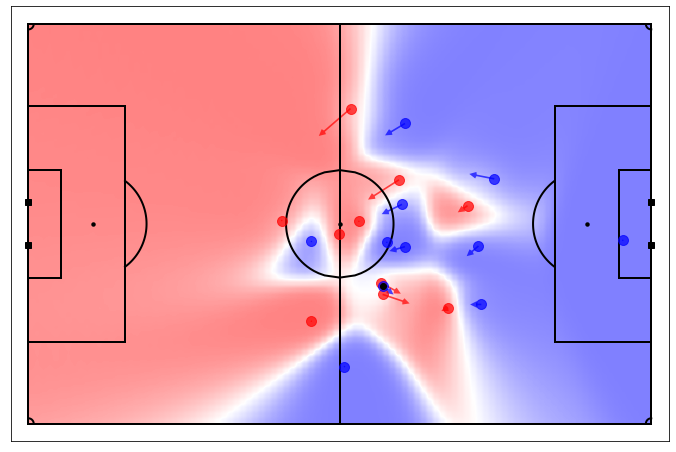

In [113]:
params = pc.default_model_params()
PPCF, xgrid, ygrid = pc.generate_pitch_control_for_frame(frame, tracking_attack, tracking_defense, params, field_dimen = (106.,68.,), n_grid_cells_x = 100)
footyviz.plot_pitchcontrol_for_frame(frame, tracking_attack, tracking_defense, PPCF, xgrid, ygrid, alpha = 0.7, include_player_velocities=True, field_dimen = (106.0,68))

## Movie pitch control

Here we will use moviepy to produce one video per play with the pitch control at each frame.

In [56]:
from moviepy import editor as mpy
from moviepy.video.io.bindings import mplfig_to_npimage

In [57]:
### Create one frame of Pitch Control

def draw_frame_pc_play(play_df, t, fps):
    
    ###Get the frame
    frame = int(t*fps)
    
    ###Select data for both teams
    tracking_attack = play_df[play_df['team'] == 'attack']
    tracking_defense = play_df[play_df['team'] == 'defense']
    
    ###Parameters of pitch control
    params = pc.default_model_params()
    
    ###Calculate pitch control map
    PPCF, xgrid, ygrid = pc.generate_pitch_control_for_frame(frame, tracking_attack, tracking_defense, params, field_dimen = (106.,68.,), n_grid_cells_x = 100)
    
    ###Draw pitch control map
    fig, ax = footyviz.plot_pitchcontrol_for_frame(frame, tracking_attack, tracking_defense, PPCF, xgrid, ygrid, alpha = 0.7, include_player_velocities=True, field_dimen = (106.0,68))

    image = mplfig_to_npimage(fig)
    plt.close()
    return image    

###Create the entire movie of pitch control for the entire play

def make_animation(play_df, fps=20):
    #calculated variables
    length = (play_df['frame'].max()+20)/fps
    clip = mpy.VideoClip(lambda x: draw_frame_pc_play(play_df, x, fps), duration=length-1).set_fps(fps)
    clip.write_videofile(list(play_df['play'])[0] + "_PC.mp4")
    return clip

## Choice of play

In [58]:
play = 'Liverpool [2] - 1 Newcastle'
play_df = data_test[data_test['play'] == play]
play_df.head(100)

,frame,bgcolor,dx,dy,edgecolor,player,player_num,team,x,y,...,vy_m,raw_speed,ax_m,ay_m,ball_x,ball_y,ball_z,possession,ball_x_m,ball_y_m
38286,0,NaN,0,0,0,0,NaN,NaN,55.9534,34.7773,...,-2.36377,3.48228,NaN,NaN,55.9534,34.7773,0,False,6.31058,-10.3514
38287,1,NaN,0.137623,0.0156225,0,0,NaN,NaN,56.091,34.793,...,-2.25516,3.32508,9.46949,2.17217,56.091,34.793,0,False,6.45646,-10.3408
38288,2,NaN,0.126459,0.000944612,0,0,NaN,NaN,56.2175,34.7939,...,-2.14748,3.22935,9.22135,2.15367,56.2175,34.7939,0,False,6.5905,-10.3401
38289,3,NaN,0.116046,-0.0127691,0,0,NaN,NaN,56.3335,34.7811,...,-2.04072,3.1957,8.97572,2.13503,56.3335,34.7811,0,False,6.71351,-10.3488
38290,4,NaN,0.106385,-0.0255186,0,0,NaN,NaN,56.4399,34.7556,...,-1.93491,3.22136,8.73258,2.11626,56.4399,34.7556,0,False,6.82628,-10.3662
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38381,95,NaN,0.282027,0.171141,0,0,NaN,NaN,92.8094,43.8804,...,2.87159,7.56665,-2.93491,-0.168292,92.8094,43.8804,0,False,45.3779,-4.16133
38382,96,NaN,0.274913,0.166824,0,0,NaN,NaN,93.0843,44.0472,...,2.8616,7.44335,-2.9482,-0.199727,93.0843,44.0472,0,False,45.6693,-4.04789
38383,97,NaN,0.267799,0.162507,0,0,NaN,NaN,93.3521,44.2097,...,2.85004,7.3189,-2.95899,-0.231299,93.3521,44.2097,0,False,45.9532,-3.93739
38384,98,NaN,0.260684,0.15819,0,0,NaN,NaN,93.6128,44.3679,...,2.83689,7.19337,-2.96729,-0.263009,93.6128,44.3679,0,False,46.2295,-3.82982


## Create Pitch Control movie for all plays
##### NB : can be very long to run and some games don't converge (too many players close to each other)

In [59]:
###List of 3 games not converging to avoid them
not_converging = ['Liverpool [4] - 0 Barcelona', 'Liverpool [3] - 0 Norwich', 'Liverpool [1] - 0 Wolves']

plays = list(data_test['play'].drop_duplicates())
for i in range(0,len(plays)) :
    game = plays[i]
    if not(game in not_converging) :
        print("Starting to create " + game)
        play_df = data_test[data_test['play'] == game]
        clip = make_animation(play_df)

Starting to create Liverpool [3] - 0 Bournemouth


t:   0%|          | 0/154 [00:00<?, ?it/s, now=None]

Moviepy - Building video Liverpool [3] - 0 Bournemouth_PC.mp4.
Moviepy - Writing video Liverpool [3] - 0 Bournemouth_PC.mp4



t:   1%|▏         | 2/154 [00:17<22:22,  8.83s/it, now=None]

KeyboardInterrupt: 

# Opponent Analysis

## Defenders' time of response

Here, we will focus on acceleration of the Liverpool's attacking players compared to defenders to highlight a key factor : time of response. 

We selected 4 plays to illustrate this point.

In [230]:
play_1 = 'Liverpool [1] - 0 Everton'
defenders_id_1 = {1847 : 'Mina', 1848 : 'Keane', 1849 : 'Holgate'} #702 : 'Digne'
attackers_id_1 = {913 : 'Origi'} #13 : 'Mané'
begin_1 = 35
end_1 = 160

play_2 = 'Liverpool [2] - 1 Newcastle'
defenders_id_2 = {2514 : 'Dummet', 2513 : 'Lascelles', 2512 : 'Schar'}
attackers_id_2 = {12 : 'Mané'} #1677 : 'Firmino', 2247 : 'Salah'
begin_2 = 15
end_2 = 90

play_3 = 'Bayern 0 - [1] Liverpool'
defenders_id_3 = {1802 : 'Rafinha', 3006 : 'Sule', 3007 : 'Hummels'}
attackers_id_3 = {13 : 'Mané'} #5608 : 'Salah'
begin_3 = 15
end_3 = 80

play_4 = 'Liverpool [2] - 0 Man City'
defenders_id_4 = {3271 : 'Fernandinho',262 : 'Angelino'} # 264 : 'Walker', 263 : 'Stones',
attackers_id_4 = {1057 : 'Salah', 4163 : 'Firmino'} #13 : 'Robertson', 5817 : 'Mané',
begin_4 = 50
end_4 = 140

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


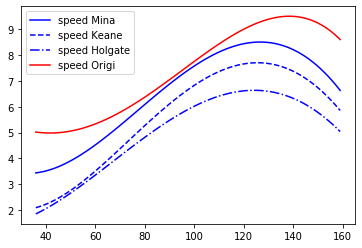

In [246]:
import matplotlib.pyplot as plt

###Selection of the action
selected_play = play_1
def_id = defenders_id_1
att_id = attackers_id_1
begin = begin_1
end = end_1

### Plotting the relevant speeds
play_df = data_test[data_test['play']==selected_play]
play_df = play_df[(play_df['frame'] > begin) & (play_df['frame'] < end)]
fig, ax = plt.subplots()

def_lines = ['b-', 'b--', 'b-.']
count_def = 0
for x in def_id:
    player_df = play_df[play_df['player'] == x]
    t = list(player_df['frame'])
    ax.plot(t, list(abs(player_df['vx_m'])), def_lines[count_def],label='speed '+def_id[x])
    count_def+=1
            
            
att_lines = ['r-', 'r--', 'r-.']            
count_att = 1   
for y in att_id:
    player_df = play_df[play_df['player'] == y]
    t = list(player_df['frame'])
    ax.plot(t, list(abs(player_df['vx_m'])),'r'+ count_att*'-' ,label='speed '+att_id[y])
    count_att += 1
    
leg = ax.legend()
plt.savefig(selected_play + 'plot', format='eps')

(<Figure size 864x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x139120e10>)

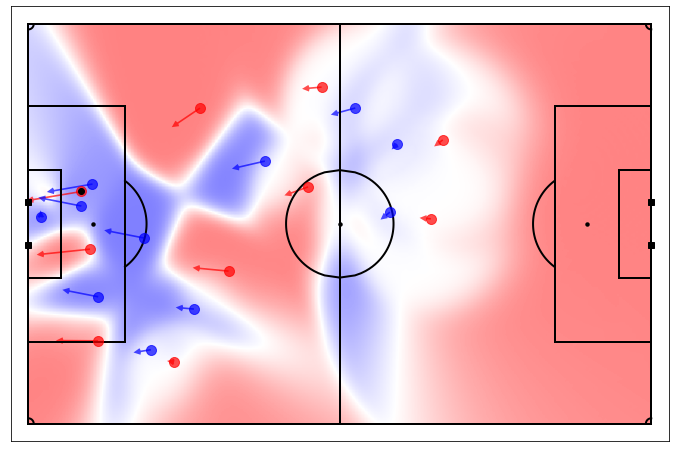

In [235]:
play = selected_play
play_df = data_test[data_test['play'] == play]
tracking_attack = play_df[play_df['team'] == 'attack']
tracking_defense = play_df[play_df['team'] == 'defense']
frame = 140
params = pc.default_model_params()
PPCF, xgrid, ygrid = pc.generate_pitch_control_for_frame(frame, tracking_attack, tracking_defense, params, field_dimen = (106.,68.,), n_grid_cells_x = 200)
footyviz.plot_pitchcontrol_for_frame(frame, tracking_attack, tracking_defense, PPCF, xgrid, ygrid, alpha = 0.7, include_player_velocities=True, field_dimen = (106.0,68))